In [8]:
import pandas as pd
from ipywidgets import interact, widgets
import plotly.express as px
from IPython.display import display
import warnings
import folium
import csv
import math
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import IFrame
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from IPython.display import HTML
import voila


In [9]:
#Read CSV
df = pd.read_csv("CSVs/fridgefills.csv")

# Change location names to string
def normalize_location(location):
    return str(location).strip().upper()

# Function to map dropoff locations to their respective names and addresses
def map_dropoff_location(location):
    normalized_location = normalize_location(location)
    if pd.isnull(normalized_location): 
        return None, None 
    if normalized_location == "BOK":
        return "BOK Fridge & Pantry", "1901 S 9th St, Philadelphia, PA, 19148"
    elif normalized_location == "PK - PEOPLE'S KITCHEN":
        return "People’s Kitchen Fridge & Pantry", "1149 S 9th Street, Philadelphia, PA, 19147"
    elif normalized_location == "DS - DISILVESTRO":
        return "DiSilvestro Playground Fridge & Pantry", "1701 S 15th Street (Between Broad and 15th on Castle Ave), Philadelphia, PA, 19145"
    elif normalized_location == "MIFFLIN":
        return "Mifflin Square Park Pantry", "516 Wolf Street, Philadelphia, PA, 19148"
    elif normalized_location == "GROWING TOGETHER/REED":
        return "Growing Together Garden Pantry", "2550 Reed Street, Philadelphia, PA, 19146"
    elif normalized_location == "PORCO'S" or normalized_location == "MAMATEE":
        return "Porco’s Philly Pantry", "1100 S 22nd Street, Philadelphia, PA, 19146"
    elif normalized_location == "LUHV":
        return "LUHV Fridge", "1840 Ellsworth Street, Philadelphia, PA, 19146"
    elif normalized_location == "CLEVELAND":
        return "Cleveland", "1542 S Cleveland St, Philadelphia, PA, 19146"
    elif normalized_location == "PB - POINT BREEZE":
        return "Point Breeze", "2100 Federal St, Philadelphia, PA, 19146"
    else:
        return None, None 

# Apply mapping function to each row
mapped_data = []
for index, row in df.iterrows():
    dropoff_location = row["Dropoff Location"]
    renamed_location, dropoff_address = map_dropoff_location(dropoff_location)
    if renamed_location is not None:  # Only append if location is recognized
        row["Dropoff Location"] = renamed_location
        row["Dropoff Address"] = dropoff_address
        mapped_data.append(row)

# Convert mapped data to df
clean_df = pd.DataFrame(mapped_data)

# Save DataFrame to CSV file
clean_df.to_csv('CSVs/clean_dataset.csv', index=False)


In [10]:
# Load new CSV
clean_df = pd.read_csv("CSVs/clean_dataset.csv")

# Add coordinates to data, coordinates from www.southphillyfridge.com/locations
locations = {
    "BOK FRIDGE & PANTRY": [39.9257126, -75.1656558],
    "DISILVESTRO PLAYGROUND FRIDGE & PANTRY": [39.9288762, -75.1730298],
    "MIFFLIN SQUARE PARK PANTRY": [39.9194993, -75.1591811],
    "CLEVELAND": [39.9316784, -75.1802706],
    "POINT BREEZE": [39.9375953, -75.1811959,],
    "PEOPLE’S KITCHEN FRIDGE & PANTRY": [39.934939, -75.163433],
    "PORCO’S PHILLY PANTRY": [39.9392245, -75.1830078],
    "GROWING TOGETHER GARDEN PANTRY": [39.9345248, -75.1898937],
    "LUHV FRIDGE": [39.9378609, -75.1775544]
}

# Add latitude and longitude to data 
def update_coordinates(row):
    location = row["Dropoff Location"]
    for key, value in locations.items():
        if location.lower() == key.lower():
            row["Latitude"] = value[0]
            row["Longitude"] = value[1]
            break
    return row
    
# Add coordinates to df
clean_df = clean_df.apply(update_coordinates, axis=1)

# Save df as new CSV
clean_df.to_csv("CSVs/updated_clean_dataset.csv", index=False)

In [11]:
# Load new dataset 
clean_df = pd.read_csv("CSVs/updated_clean_dataset.csv")

# Function to create choropleth map using Folium
def create_choropleth_map(csv_file):
    m = folium.Map(location=[39.9526, -75.1652], zoom_start=13, tiles='OpenStreetMap')

    # Read CSV file and count donations for each location
    donation_counts = {}
    locations = {}
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            lat = float(row['Latitude'])
            lon = float(row['Longitude'])
            location = row['Dropoff Location']
            donation_counts[(lat, lon)] = donation_counts.get((lat, lon), 0) + 1
            locations[(lat, lon)] = location

   
    colormap = cm.get_cmap('tab10', len(donation_counts))

    # Add markers to the map based on donation counts
    for i, ((lat, lon), count) in enumerate(donation_counts.items()):
        # Convert index to color from the colormap
        color = colors.rgb2hex(colormap(i))

        # Set marker size based on donation count
        marker_size = math.sqrt(count) * 2

        # Add marker to the map
        popup_text = f'<div style="width:250px; height:40px;"><b>Dropoff Location:</b> {locations[(lat, lon)]}<br><b>Donations:</b> {count}</div>'
        folium.CircleMarker(location=[lat, lon], radius=marker_size, color=color, fill=True, fill_opacity=0.6,
                            popup=popup_text).add_to(m)

    # Create legend
    legend_html = '''
        <div style="position: fixed; 
                    top: 10px; right: 10px; width: 150px; height: 250px; 
                    background-color: white; border-radius: 5px; z-index:9999;
                    padding: 10px; font-size: 10px;">
            <b>Legend</b><br>
    '''
    for i, (location, _) in enumerate(donation_counts.items()):
        legend_html += f'<i style="background:{colors.rgb2hex(colormap(i))}; width: 10px; height: 10px; display:inline-block"></i> {locations[location]}<br>'
    legend_html += '</div>'
    
    # Add legend to map
    m.get_root().html.add_child(folium.Element(legend_html))

    # Convert map to HTML
    html_map = m._repr_html_()

    return html_map

# Call the function to create the choropleth map
html_map = create_choropleth_map('CSVs/updated_clean_dataset.csv')

# HTML for the banner with an image
banner_html = '''
<div style="background-color:#007BFF;color:white;text-align:center;padding:20px;">
    <h1>South Philadelphia Community Fridge</h1>
    <div style="display: flex; justify-content: center;">
        <div style="margin-right: 20px;">
            <img src="Images/img1.jpg" alt="Image 1" style="width: 150px;height: 150px;border-radius: 50%;">
        </div>
        <div>
            <img src="Images/img2.jpg" alt="Image 2" style="width: 150px;height: 150px;border-radius: 50%;">
        </div>
    </div>
    <p style="text-align: justify; margin: 0 auto; max-width: 800px;">Our project analyzes data on food donation from South Philadelphia Community Fridge. South Philadelphia Community Fridge is an all-volunteer mutual aid organization in the South Philadelphia neighborhood that provides 24/7 no-questions-asked food aid through a network of free fridges and pantries</p>

</div>
'''

# Display banner and map
HTML(banner_html + html_map)

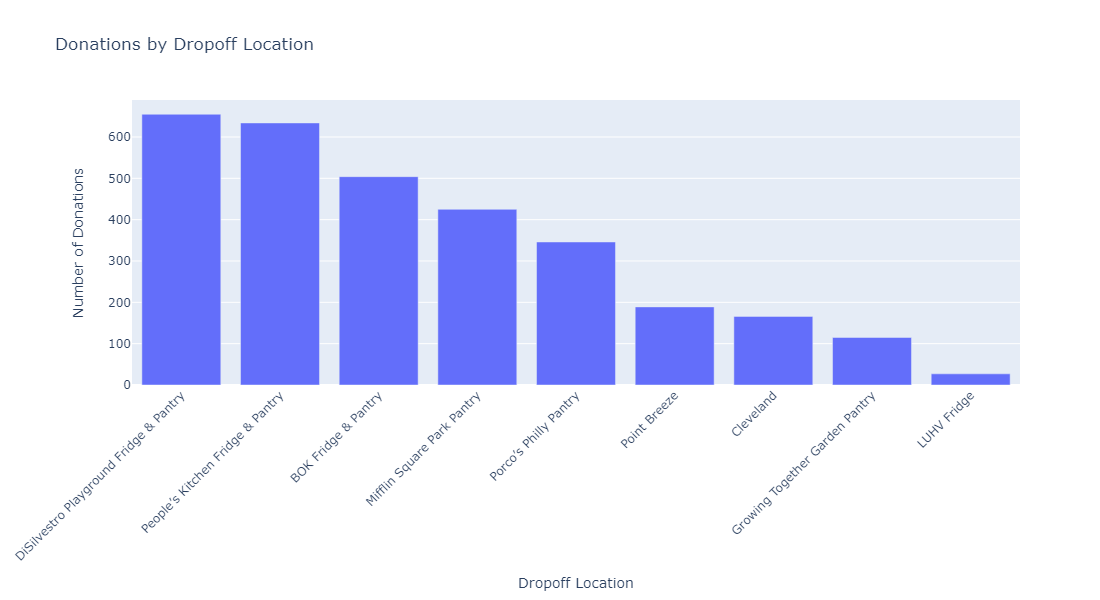

In [12]:
# Read data from CSV
df = pd.read_csv('CSVs/updated_clean_dataset.csv')


# Count the occurrences of each dropoff location
dropoff_location_counts = df['Dropoff Location'].value_counts()

# Create a bar trace
trace = go.Bar(
    x=dropoff_location_counts.index,
    y=dropoff_location_counts.values,
)

# Create layout
layout = go.Layout(
    title='Donations by Dropoff Location',
    xaxis=dict(title='Dropoff Location'),
    yaxis=dict(title='Number of Donations'),
    xaxis_tickangle=-45,
    height=600,
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Set the x-axis tick values to match the updated dropoff locations
fig.update_xaxes(tickvals=dropoff_location_counts.index)

# Show the plot
fig.show()

In [13]:
# Define the list of locations with their start and end dates. Start and end dates obtained from volunteers of South Philadelphia Community Fridge
locations = [
    {"name": "BOK FRIDGE & PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "DISILVESTRO PLAYGROUND FRIDGE & PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "MIFFLIN SQUARE PARK PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "CLEVELAND", "start_date": "1/1/2023", "end_date": "6/23/2023"},
    {"name": "POINT BREEZE", "start_date": "1/1/2023", "end_date": "5/4/2023"},
    {"name": "PEOPLE’S KITCHEN FRIDGE & PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "PORCO’S PHILLY PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "GROWING TOGETHER GARDEN PANTRY", "start_date": "9/21/2023", "end_date": "12/31/2023"},
    {"name": "LUHV FRIDGE", "start_date": "12/9/2023", "end_date": "12/31/2023"}
]

# Function to calculate the number of days between two dates
def calculate_days(start_date, end_date):
    start = datetime.strptime(start_date, "%m/%d/%Y")
    end = datetime.strptime(end_date, "%m/%d/%Y")
    return (end - start).days

# Convert the names in locations list to all caps
for location in locations:
    location['name'] = location['name'].upper()

print("Total Days in Operation")
# Calculate and print the days for each location
for location in locations:
    days = calculate_days(location["start_date"], location["end_date"])
    print(f"{location['name']}: {days} days")

# Convert the 'Dropoff Location' values in clean_df to all caps
clean_df['Dropoff Location'] = clean_df['Dropoff Location'].str.upper()

# Define the desired order of locations
desired_order = [location['name'] for location in locations]

# Reorder the 'fill_location_counts' Series according to the desired order
fill_location_counts = clean_df['Dropoff Location'].value_counts().reindex(desired_order)
print(" ")
print("Total Number of Dropoffs")
fill_location_counts


Total Days in Operation
BOK FRIDGE & PANTRY: 364 days
DISILVESTRO PLAYGROUND FRIDGE & PANTRY: 364 days
MIFFLIN SQUARE PARK PANTRY: 364 days
CLEVELAND: 173 days
POINT BREEZE: 123 days
PEOPLE’S KITCHEN FRIDGE & PANTRY: 364 days
PORCO’S PHILLY PANTRY: 364 days
GROWING TOGETHER GARDEN PANTRY: 101 days
LUHV FRIDGE: 22 days
 
Total Number of Dropoffs


Dropoff Location
BOK FRIDGE & PANTRY                       504
DISILVESTRO PLAYGROUND FRIDGE & PANTRY    655
MIFFLIN SQUARE PARK PANTRY                425
CLEVELAND                                 166
POINT BREEZE                              189
PEOPLE’S KITCHEN FRIDGE & PANTRY          634
PORCO’S PHILLY PANTRY                     346
GROWING TOGETHER GARDEN PANTRY            115
LUHV FRIDGE                                27
Name: count, dtype: int64

In [14]:
print("Average Donations for All Days in Operation")
for location in locations:
    days = calculate_days(location["start_date"], location["end_date"])
    fill_location_count = fill_location_counts[location['name']]
    fill_location_count_per_day = fill_location_count / days
    print(f"{location['name']}: {round(fill_location_count_per_day, 2)} donations per day")

Average Donations for All Days in Operation
BOK FRIDGE & PANTRY: 1.38 donations per day
DISILVESTRO PLAYGROUND FRIDGE & PANTRY: 1.8 donations per day
MIFFLIN SQUARE PARK PANTRY: 1.17 donations per day
CLEVELAND: 0.96 donations per day
POINT BREEZE: 1.54 donations per day
PEOPLE’S KITCHEN FRIDGE & PANTRY: 1.74 donations per day
PORCO’S PHILLY PANTRY: 0.95 donations per day
GROWING TOGETHER GARDEN PANTRY: 1.14 donations per day
LUHV FRIDGE: 1.23 donations per day


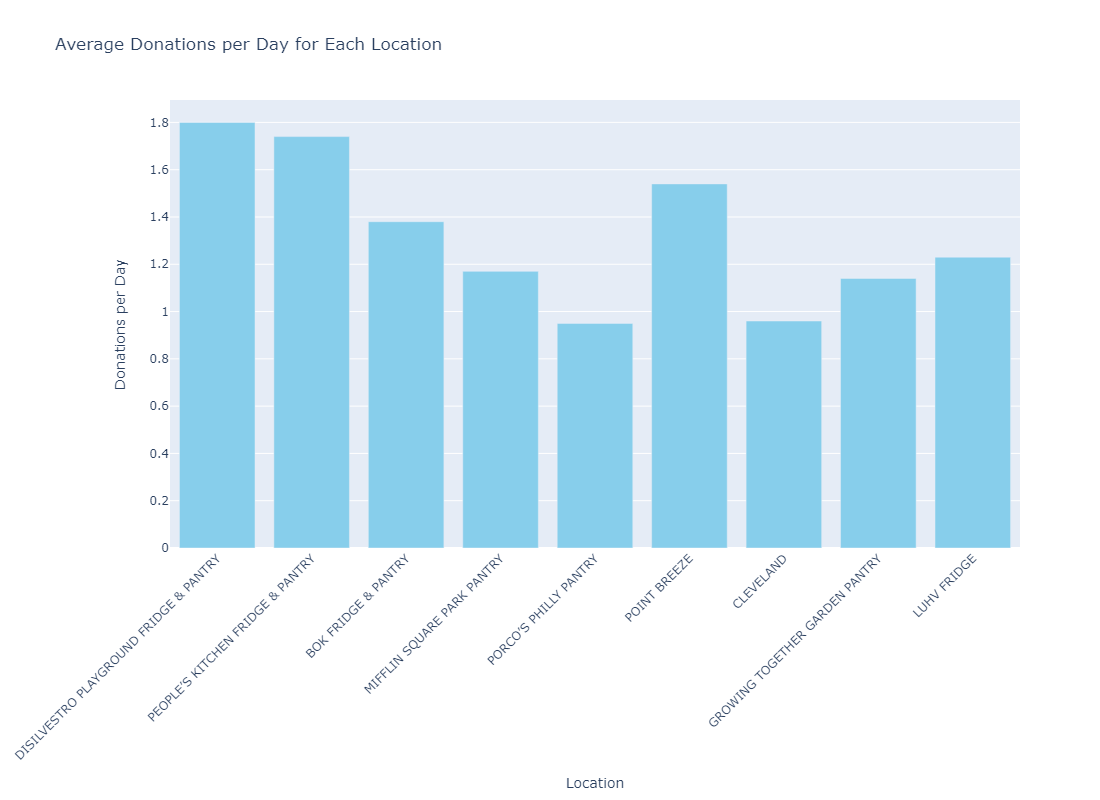

In [15]:
# Define the list of locations with their start and end dates
locations = [
    {"name": "DISILVESTRO PLAYGROUND FRIDGE & PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "PEOPLE’S KITCHEN FRIDGE & PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "BOK FRIDGE & PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "MIFFLIN SQUARE PARK PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "PORCO’S PHILLY PANTRY", "start_date": "1/1/2023", "end_date": "12/31/2023"},
    {"name": "POINT BREEZE", "start_date": "1/1/2023", "end_date": "5/4/2023"},
    {"name": "CLEVELAND", "start_date": "1/1/2023", "end_date": "6/23/2023"},
    {"name": "GROWING TOGETHER GARDEN PANTRY", "start_date": "9/21/2023", "end_date": "12/31/2023"},
    {"name": "LUHV FRIDGE", "start_date": "12/9/2023", "end_date": "12/31/2023"}
]

# Function to calculate the number of days between two dates
def calculate_days(start_date, end_date):
    start = datetime.strptime(start_date, "%m/%d/%Y")
    end = datetime.strptime(end_date, "%m/%d/%Y")
    return (end - start).days

# Convert the names in locations list to all caps
for location in locations:
    location['name'] = location['name'].upper()

# Calculate fill location counts divided by days for each location
entries_per_day = []
for location in locations:
    days = calculate_days(location["start_date"], location["end_date"])
    fill_location_count = fill_location_counts.get(location['name'], 0)  # Get count from fill_location_counts or default to 0 if not found
    fill_location_count_per_day = fill_location_count / days
    entries_per_day.append(round(fill_location_count_per_day, 2))

# Create bar plot
fig = go.Figure([go.Bar(x=[location['name'] for location in locations], y=entries_per_day, marker_color='skyblue')])
fig.update_layout(
    title='Average Donations per Day for Each Location',
    xaxis=dict(title='Location'),
    yaxis=dict(title='Donations per Day'),
    xaxis_tickangle=-45,
    height=800 
)

# Show plot
fig.show()


In [16]:
# Read data from CSV file
df = pd.read_csv('CSVs/clean_dataset.csv')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Drop '_id' column if it exists
if '_id' in df.columns:
    df.drop('_id', axis=1, inplace=True)

# Create a copy of the DataFrame with datetime 'Date' column
df_dates = df.copy()

# Define function to plot entries per month
def plot_entries_per_month(fill_type):
    if fill_type == 'All Fill Types':
        filtered_df = df_dates.copy()  
    else:
        filtered_df = df_dates[df_dates['Fill Type'] == fill_type].copy()  

    # Ensure datetime column has timezone information
    filtered_df['Date'] = filtered_df['Date'].dt.tz_localize(None)  # Remove any existing timezone information

    # Convert 'Date' column to Periods
    filtered_df.loc[:, 'YearMonth'] = filtered_df['Date'].dt.to_period('M').dt.strftime('%B')  

    monthly_counts = filtered_df.groupby('YearMonth').size().reset_index(name='Total Entries')

    # Sort monthly_counts by 'YearMonth'
    monthly_counts['YearMonth'] = pd.Categorical(monthly_counts['YearMonth'], 
                                                 categories=['January', 'February', 'March', 'April', 'May', 'June', 
                                                             'July', 'August', 'September', 'October', 'November', 'December'], 
                                                 ordered=True)
    monthly_counts = monthly_counts.sort_values('YearMonth')

    # Set figure size
    fig = px.bar(monthly_counts, x='YearMonth', y='Total Entries', 
                 labels={'YearMonth': 'Month', 'Total Entries': 'Total Entries'},
                 title=f'Total Fills per Month for {fill_type} in 2023')

    fig.update_layout(xaxis_tickangle=-45, yaxis_gridcolor='lightgrey', 
                      width=800, height=500) 
    fig.show()

# Get unique values of 'Fill Type' for dropdown menu excluding 'nan'
fill_types = df_dates['Fill Type'].dropna().unique()
fill_types = list(fill_types)
fill_types.append('All Fill Types')  

# Create interactive dropdown menu
interact(plot_entries_per_month, fill_type=widgets.Dropdown(options=fill_types, description='Fill Type:'))


interactive(children=(Dropdown(description='Fill Type:', options=('Rescued Groceries', 'Purchased Groceries', …

<function __main__.plot_entries_per_month(fill_type)>

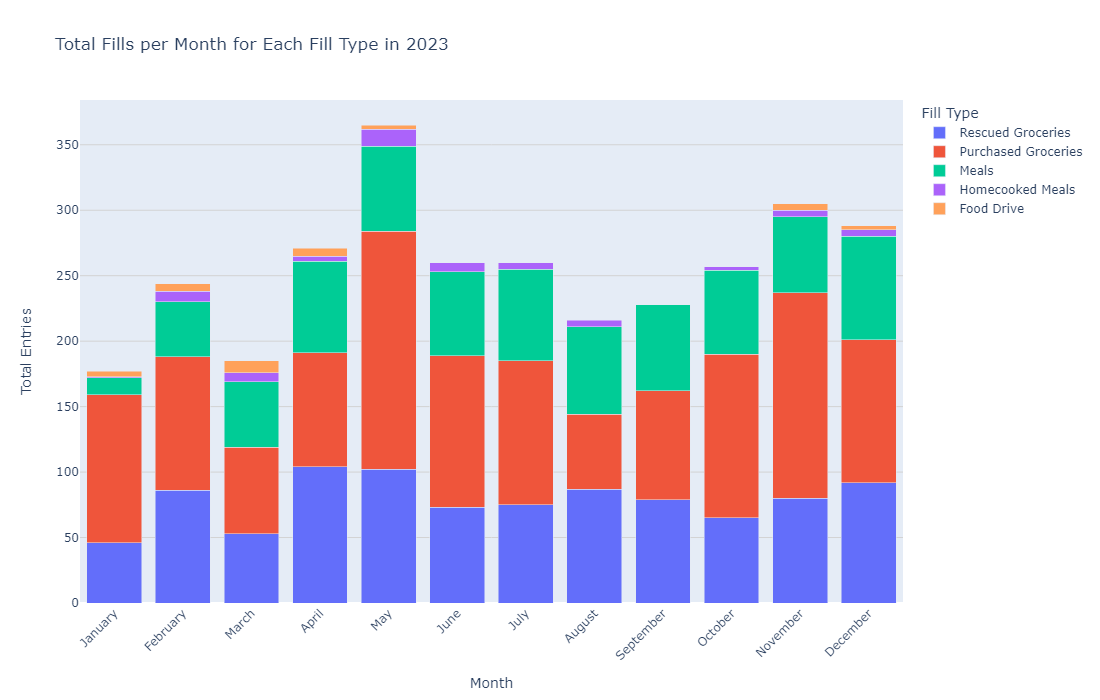

In [11]:
# Read data from JSON file
df = pd.read_csv('CSVs/clean_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])


# Create a copy of the DataFrame with datetime 'Date' column
df_dates = df.copy()


# Convert 'Date' column to Periods
df_dates.loc[:, 'YearMonth'] = df_dates['Date'].dt.to_period('M').dt.strftime('%B')  

# Group by 'YearMonth' and 'Fill Type' to count entries for each combination
monthly_counts = df_dates.groupby(['YearMonth', 'Fill Type']).size().reset_index(name='Total Entries')

# Sort 'YearMonth' by month order
monthly_counts['YearMonth'] = pd.Categorical(monthly_counts['YearMonth'], 
                                             categories=['January', 'February', 'March', 'April', 'May', 'June', 
                                                         'July', 'August', 'September', 'October', 'November', 'December'], 
                                             ordered=True)
monthly_counts = monthly_counts.sort_values('YearMonth')

# Set figure size
fig = px.bar(monthly_counts, x='YearMonth', y='Total Entries', 
             color='Fill Type', 
             labels={'YearMonth': 'Month', 'Total Entries': 'Total Entries', 'Fill Type': 'Fill Type'},
             title='Total Fills per Month for Each Fill Type in 2023',
             barmode='stack')

fig.update_layout(xaxis_tickangle=-45, yaxis_gridcolor='lightgrey', 
                  width=1100, height=700) 

# Display the graph
display(fig)


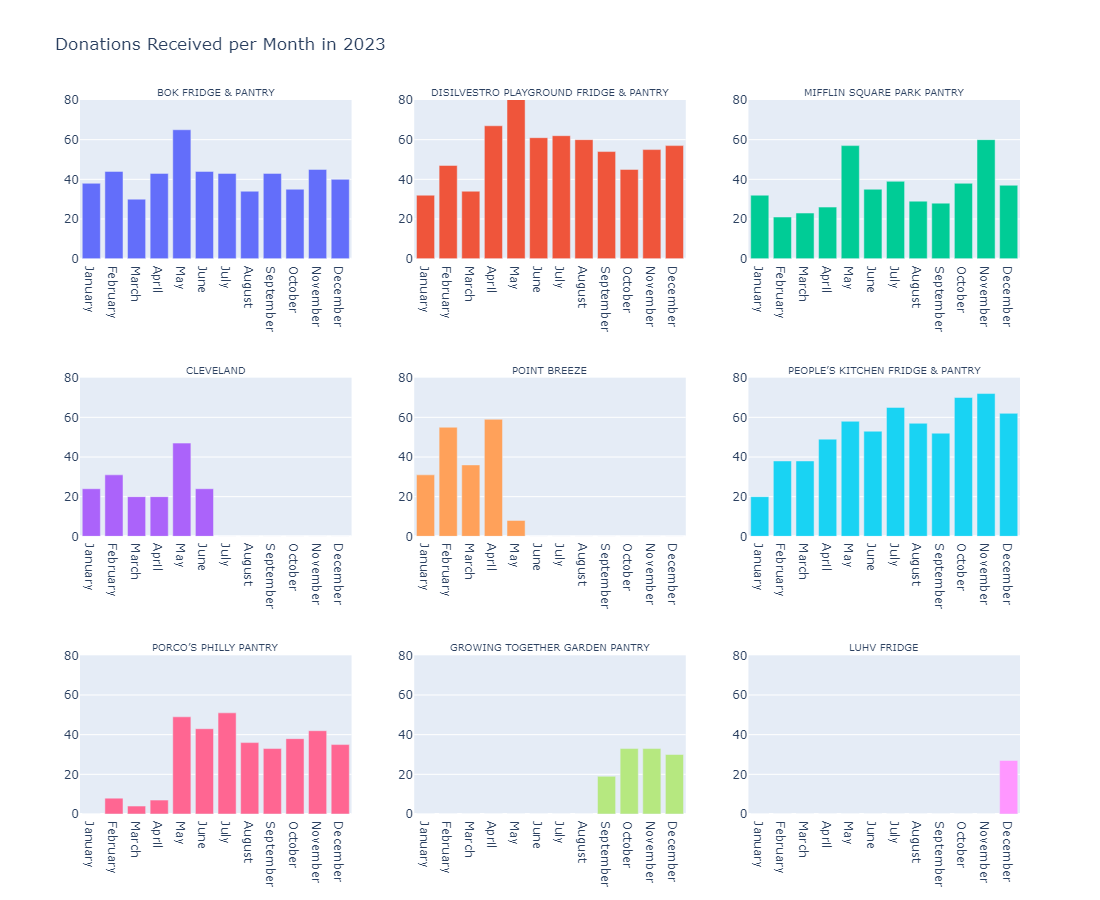

In [17]:
# Convert 'Date' column to datetime format
clean_df['Date'] = pd.to_datetime(clean_df['Date'])

# Extract unique locations from clean_df
unique_locations_combined = clean_df['Dropoff Location'].unique()

# Create an empty list to store all subplot traces
subplot_traces = []

# Iterate through each unique location
for idx, location in enumerate(unique_locations_combined, start=1):
    # Filter DataFrame for the current location
    location_df_filtered = clean_df[clean_df['Dropoff Location'] == location].copy()

    # Localize 'Date' column to remove timezone information
    location_df_filtered['Date'] = location_df_filtered['Date'].dt.tz_localize(None)

    # Convert 'Date' column to PeriodArray/Index representation
    location_df_filtered['YearMonth'] = location_df_filtered['Date'].dt.to_period('M').dt.strftime('%B')

    # Calculate the number of donations received every month for the current location
    monthly_counts = location_df_filtered.groupby('YearMonth').size().reindex(pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS').strftime('%B'), fill_value=0).reset_index(name='Donation Count')

    # Create a bar trace for the current location
    trace = go.Bar(x=monthly_counts['index'], y=monthly_counts['Donation Count'], name=location)

    # Append the trace to the subplot_traces list
    subplot_traces.append(trace)

    # If the subplot_traces list contains 9 traces or it's the last iteration, create a subplot
    if len(subplot_traces) == 9 or idx == len(unique_locations_combined):
        # Create a subplot figure with a 3x3 grid
        fig = make_subplots(rows=3, cols=3, subplot_titles=[trace.name.upper() for trace in subplot_traces])

        # Add traces to the subplot figure
        for row in range(3):
            for col in range(3):
                trace_idx = row * 3 + col
                if trace_idx < len(subplot_traces):
                    fig.add_trace(subplot_traces[trace_idx], row=row+1, col=col+1)

        # Update figure layout to hide the legend
        fig.update_layout(height=900, width=1000, title_text="Donations Received per Month in 2023", showlegend=False)
        fig.update_annotations(font=dict(size=10))

        # Update x-axis to display all 12 months
        fig.update_xaxes(tickvals=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS').strftime('%B'))
        fig.update_yaxes(range=[0, 80])

        # Show the subplot figure
        fig.show()

        # Reset subplot_traces list for the next set of traces
        subplot_traces = []


In [18]:
# Convert the "Date" column to datetime objects
df_dates['Date'] = pd.to_datetime(df_dates['Date'])

def plot_donations_by_month(month):
    # Static year value
    year = 2023
    
    # Filter the DataFrame for the selected month and year
    monthly_data = df_dates.loc[(df_dates['Date'].dt.year == year) & (df_dates['Date'].dt.month == month)]
    
    # Group the data by date and time of day and count the number of donations for each group
    monthly_donations = monthly_data.groupby(['Date', 'Time of Day']).size().unstack(fill_value=0)
    
    # Reset index to ensure 'Date' is a column for Plotly
    monthly_donations = monthly_donations.reset_index()
    
    # Plot the data
    fig = px.line(monthly_donations, x='Date', y=monthly_donations.columns[1:], 
                  title=f'Donations by Time of Day in {month}/2023', 
                  labels={'Date': 'Date', 'value': 'Number of Donations', 'variable': 'Time of Day'})
    fig.update_xaxes(tickangle=45)
    fig.show()

# Define the options for the dropdown menu
months = range(1, 13)  # January to December

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create interactive dropdown menu for month
interact(plot_donations_by_month, month=months)

interactive(children=(Dropdown(description='month', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1),…

<function __main__.plot_donations_by_month(month)>

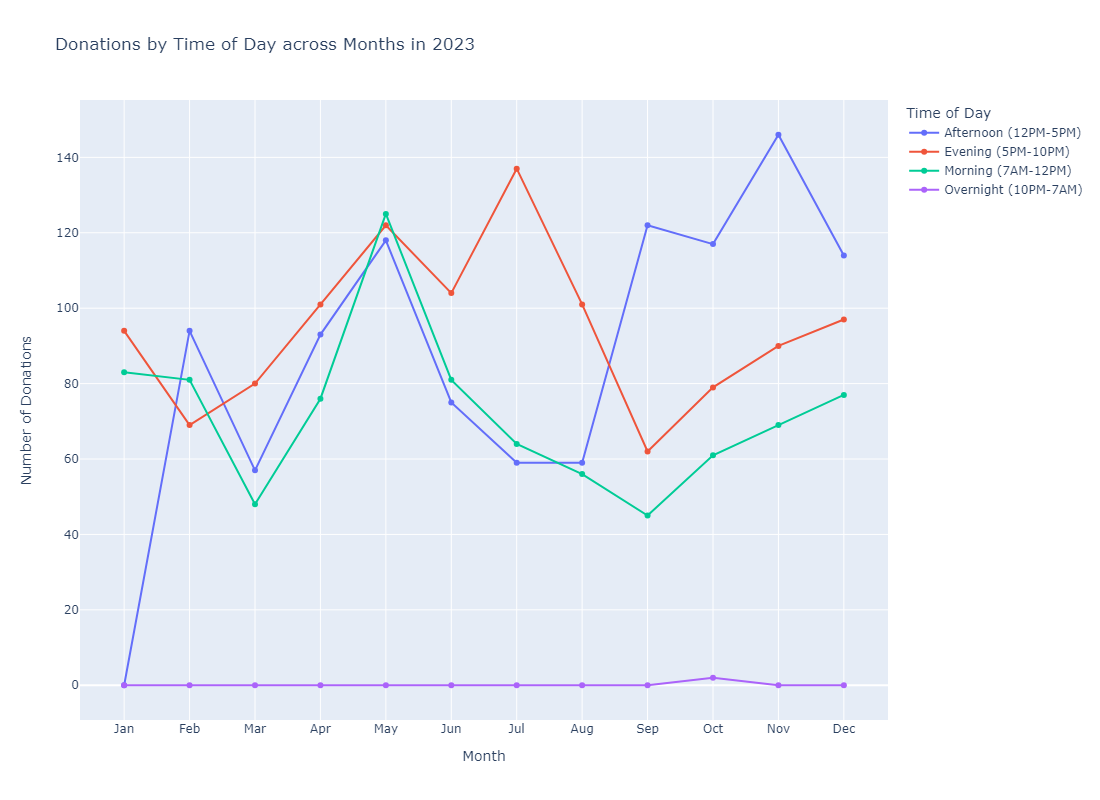

In [14]:

# Convert the "Date" column to datetime objects
df_dates['Date'] = pd.to_datetime(df_dates['Date'])

# Group the data by month and time of day and count the number of donations for each group
monthly_donations = df_dates.groupby([df_dates['Date'].dt.month, 'Time of Day']).size().unstack(fill_value=0)

# Plot the data
fig = go.Figure()

# Add traces for each time of day
for time_of_day in monthly_donations.columns:
    fig.add_trace(go.Scatter(x=monthly_donations.index, y=monthly_donations[time_of_day], mode='lines+markers', name=time_of_day))

# Update layout
fig.update_layout(
    title='Donations by Time of Day across Months in 2023',
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    yaxis=dict(
        title='Number of Donations'
    ),
    legend=dict(
        title='Time of Day'
    ),
    hovermode='closest',
    height=800  
)

# Show plot
fig.show()
